In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import explained_variance_score
from sklearn import preprocessing
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, SimpleRNN
from keras import Input
from keras.models import Sequential
from sklearn.model_selection import StratifiedKFold, KFold

# Gives warning bug see: https://github.com/pandas-dev/pandas/issues/39554
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Whether to read realistic data file or nooutliers data file. 
df = pd.read_csv('realistic_data.csv')
#df = pd.read_csv('nooutliers_data.csv')

# Whether to plot everything or not
PLOT_EDA2 = False

In [159]:
# Create columns for variables that have a value
for var in df["variable"].unique():
    df['%s'%var] = np.where(df['variable'] == var, df['value'], np.NaN)

# Split the date-time in seperate columns, transform to a datetime format
df[['date', 'time']] = df['time'].str.split(' ', 1, expand=True)
df['time'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%Y-%m-%d %H:%M:%S.%f')

# Print example
df.head()

,Unnamed: 0,index,Unnamed: 0.1,id,time,variable,value,mood,circumplex.arousal,circumplex.valence,...,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,date
0,0,0,1,1,2014-02-26 13:00:00,mood,6.0,6.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-02-26
1,1,1,2,1,2014-02-26 15:00:00,mood,6.0,6.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-02-26
2,2,2,3,1,2014-02-26 18:00:00,mood,6.0,6.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-02-26
3,3,3,4,1,2014-02-26 21:00:00,mood,7.0,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-02-26
4,4,4,5,1,2014-02-27 09:00:00,mood,6.0,6.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-02-27


In [160]:
# Pick one sample user

def create_merged_dataset(df):
    frames = []
    unique_users = df['id'].unique()
    for uu in unique_users:
        df1 = df[df['id'] == uu]
        df_avg = pd.DataFrame()

        # Average over the day
        take_mean = set(("mood", "activity", "circumplex.arousal", "circumplex.valence"))

        # Total time everyday
        take_sum = set(("screen", "appCat.builtin","appCat.communication","appCat.entertainment", 
                        "appCat.finance", "appCat.game", "appCat.office", "appCat.other", "appCat.social",  
                        "appCat.travel", "appCat.unknown", "appCat.utilities", "appCat.weather"))

        # Amount of calls or texts a day
        take_count = set(("call", "sms"))

        for var in df["variable"].unique():
            df2 = df1[df1[var].notna()]
            if var in take_mean:
                df_mean = df2.groupby('date').mean()
                df_avg[var] = df_mean[var]
            if var in take_sum:
                df_sum = df2.groupby('date').mean()
                df_avg[var] = df_sum[var]
            if var in take_count:
                df_count = df2.groupby('date').count()
                df_avg[var] = df_count[var]
        
        df_avg["id"] = uu
        
        # Provide benchmark mood by taking mood from day before
        df_avg["Benchmark_mood_pred"] = df_avg.mood.shift(1)
        
        frames.append(df_avg)
        

    df_merged = pd.concat(frames)
    col = df_merged.pop("id")
    df_merged.insert(0, col.name, col)
    return df_merged

df_merged = create_merged_dataset(df)
#print('Dataset with all id, not yet aggregated the values for different time periods')
dfa1401 = df_merged[df_merged['id']=='AS14.01']
print('length of merged dataset:', len(df_merged))
print(df_merged.isna().sum())
df_merged.head()

length of merged dataset: 1268
id                         0
mood                       0
circumplex.arousal         0
circumplex.valence         2
activity                 118
screen                   100
call                     528
sms                      840
appCat.builtin           111
appCat.communication     121
appCat.entertainment     445
appCat.finance          1062
appCat.game             1079
appCat.office            998
appCat.other             165
appCat.social            306
appCat.travel            850
appCat.unknown          1013
appCat.utilities         844
appCat.weather          1157
Benchmark_mood_pred       27
dtype: int64


,id,mood,circumplex.arousal,circumplex.valence,activity,screen,call,sms,appCat.builtin,appCat.communication,...,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,Benchmark_mood_pred
date,,,,,,,,,,,,,,,,,,,,,
2014-02-26,1,6.250000,-0.25,0.750000,NaN,NaN,1.0,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-27,1,6.333333,0.00,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.250000
2014-03-21,1,6.200000,0.20,0.200000,0.134050,81.254545,6.0,NaN,5.962021,47.019804,...,3.8294,NaN,57.402,29.968875,64.902404,39.064,NaN,11.32795,NaN,6.333333
2014-03-22,1,6.400000,0.60,0.500000,0.236880,35.787491,3.0,1.0,4.530716,36.687838,...,6.5255,NaN,NaN,14.020429,25.252900,37.305,NaN,39.20700,NaN,6.200000
2014-03-23,1,6.800000,0.20,0.800000,0.142741,56.007602,NaN,NaN,5.342474,45.717667,...,11.4110,NaN,NaN,12.137167,47.533333,NaN,NaN,30.08600,30.386,6.400000


In [161]:
# change NaN to 0
df = df_merged.replace(np.nan, 0)

# Normalize circumplex values using min-max normalization
df['circumplex.arousal'] =(df['circumplex.arousal']-df['circumplex.arousal'].min())/(df['circumplex.arousal'].max()-df['circumplex.arousal'].min())
df['circumplex.valence'] = (df['circumplex.valence']-df['circumplex.valence'].min())/(df['circumplex.valence'].max()-df['circumplex.valence'].min())

# Use sqrt sqrt transformation
df[no_mood] = np.sqrt(df[no_mood])
df[no_mood] = np.sqrt(df[no_mood])

# Replace zero's for very small values - remove 2 zero's to get better view
df = df.replace(0, 0.00000001)
df

,id,mood,circumplex.arousal,circumplex.valence,activity,screen,call,sms,appCat.builtin,appCat.communication,...,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,Benchmark_mood_pred
date,,,,,,,,,,,,,,,,,,,,,
2014-02-26,1,6.250000,4.375000e-01,0.615385,1.000000e-08,1.000000e-08,1.000000e+00,2.000000e+00,1.000000e-08,1.000000e-08,...,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08
2014-02-27,1,6.333333,5.000000e-01,0.487179,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,...,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,6.250000e+00
2014-03-21,1,6.200000,5.500000e-01,0.446154,1.340501e-01,8.125455e+01,6.000000e+00,1.000000e-08,5.962021e+00,4.701980e+01,...,3.829400e+00,1.000000e-08,5.740200e+01,2.996888e+01,6.490240e+01,3.906400e+01,1.000000e-08,1.132795e+01,1.000000e-08,6.333333e+00
2014-03-22,1,6.400000,6.500000e-01,0.538462,2.368802e-01,3.578749e+01,3.000000e+00,1.000000e+00,4.530716e+00,3.668784e+01,...,6.525500e+00,1.000000e-08,1.000000e-08,1.402043e+01,2.525290e+01,3.730500e+01,1.000000e-08,3.920700e+01,1.000000e-08,6.200000e+00
2014-03-23,1,6.800000,5.500000e-01,0.630769,1.427411e-01,5.600760e+01,1.000000e-08,1.000000e-08,5.342474e+00,4.571767e+01,...,1.141100e+01,1.000000e-08,1.000000e-08,1.213717e+01,4.753333e+01,1.000000e-08,1.000000e-08,3.008600e+01,3.038600e+01,6.400000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-05-27,33,6.200000,3.500000e-01,0.507692,1.270424e-02,9.307912e+01,1.000000e+00,2.000000e+00,4.284850e+00,5.161880e+01,...,1.000000e-08,1.000000e-08,1.000000e-08,1.783575e+01,2.708853e+01,1.000000e-08,1.000000e-08,1.001000e+00,1.000000e-08,5.400000e+00
2014-05-28,33,8.200000,5.000000e-01,0.753846,1.033012e-01,7.731336e+01,1.000000e+01,1.000000e+00,5.589461e+00,2.935863e+01,...,1.000000e-08,1.000000e-08,4.085643e+01,2.347944e+01,5.925142e+01,1.000000e-08,1.000000e-08,5.111000e+00,1.000000e-08,6.200000e+00
2014-05-29,33,7.000000,1.666667e-01,0.692308,1.693545e-01,6.712785e+01,5.000000e+00,1.000000e+00,5.470679e+00,4.965786e+01,...,1.000000e-08,1.000000e-08,1.000000e-08,9.734000e+00,1.803813e+02,9.390000e-01,1.000000e-08,1.599500e+00,1.000000e-08,8.200000e+00


In [162]:
def print_plot_eda2(df):
    # distribution plots of all variables
    df.hist(figsize=(16, 20), bins=10, xlabelsize=8, ylabelsize=8);
    
    # only valence correlated, however nothing done with outliers
    df_avg_corr = df.corr()['mood'][1:]
    golden_features_list = df_avg_corr[abs(df_avg_corr) > 0.4].sort_values(ascending=False)
    print("There is {} strongly correlated values with mood:\n{}".format(len(golden_features_list), golden_features_list))
    
    # scatterplots of all variables against mood
    for i in range(1, len(df.columns)+1, 5):
        sns.pairplot(data=df,
                    x_vars=df.columns[i:i+5],
                    y_vars=['mood'])
        
    # call correlates 1 on 1 with  app unknown and sms 1 on 1 with app office
    corr = df.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr[(corr >= 0.4) | (corr <= -0.4)], 
                cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
                annot=True, annot_kws={"size": 8}, square=True);
    
    features_to_analyse = [x for x in df.columns if x in golden_features_list]
    print('features to analyse:', features_to_analyse)
    
    ''' fig, ax = plt.subplots(round(len(features_to_analyse) / 3), 3, figsize = (18, 12))

    for i, ax in enumerate(fig.axes):
        if i < len(features_to_analyse) - 1:
            sns.regplot(x=features_to_analyse[i],y='mood', data=df[features_to_analyse], ax=ax)'''
    
    return

if PLOT_EDA2:
    print_plot_eda2(df)

df

,id,mood,circumplex.arousal,circumplex.valence,activity,screen,call,sms,appCat.builtin,appCat.communication,...,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,Benchmark_mood_pred
date,,,,,,,,,,,,,,,,,,,,,
2014-02-26,1,6.250000,4.375000e-01,0.615385,1.000000e-08,1.000000e-08,1.000000e+00,2.000000e+00,1.000000e-08,1.000000e-08,...,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08
2014-02-27,1,6.333333,5.000000e-01,0.487179,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,...,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,6.250000e+00
2014-03-21,1,6.200000,5.500000e-01,0.446154,1.340501e-01,8.125455e+01,6.000000e+00,1.000000e-08,5.962021e+00,4.701980e+01,...,3.829400e+00,1.000000e-08,5.740200e+01,2.996888e+01,6.490240e+01,3.906400e+01,1.000000e-08,1.132795e+01,1.000000e-08,6.333333e+00
2014-03-22,1,6.400000,6.500000e-01,0.538462,2.368802e-01,3.578749e+01,3.000000e+00,1.000000e+00,4.530716e+00,3.668784e+01,...,6.525500e+00,1.000000e-08,1.000000e-08,1.402043e+01,2.525290e+01,3.730500e+01,1.000000e-08,3.920700e+01,1.000000e-08,6.200000e+00
2014-03-23,1,6.800000,5.500000e-01,0.630769,1.427411e-01,5.600760e+01,1.000000e-08,1.000000e-08,5.342474e+00,4.571767e+01,...,1.141100e+01,1.000000e-08,1.000000e-08,1.213717e+01,4.753333e+01,1.000000e-08,1.000000e-08,3.008600e+01,3.038600e+01,6.400000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-05-27,33,6.200000,3.500000e-01,0.507692,1.270424e-02,9.307912e+01,1.000000e+00,2.000000e+00,4.284850e+00,5.161880e+01,...,1.000000e-08,1.000000e-08,1.000000e-08,1.783575e+01,2.708853e+01,1.000000e-08,1.000000e-08,1.001000e+00,1.000000e-08,5.400000e+00
2014-05-28,33,8.200000,5.000000e-01,0.753846,1.033012e-01,7.731336e+01,1.000000e+01,1.000000e+00,5.589461e+00,2.935863e+01,...,1.000000e-08,1.000000e-08,4.085643e+01,2.347944e+01,5.925142e+01,1.000000e-08,1.000000e-08,5.111000e+00,1.000000e-08,6.200000e+00
2014-05-29,33,7.000000,1.666667e-01,0.692308,1.693545e-01,6.712785e+01,5.000000e+00,1.000000e+00,5.470679e+00,4.965786e+01,...,1.000000e-08,1.000000e-08,1.000000e-08,9.734000e+00,1.803813e+02,9.390000e-01,1.000000e-08,1.599500e+00,1.000000e-08,8.200000e+00


In [163]:
## Transform data period based on delta 5 timeperiod
delta = 5

# See https://sparkbyexamples.com/pandas/pandas-rolling-mean-average-sum/

pd.options.mode.chained_assignment = None  # default='warn'

def merge_on_delta(df,delta):
    frames = []
    unique_users = df['id'].unique()
    for uu in unique_users:
        df_user = df[df['id']==uu]
        
        # Get moving average of all columns except target / benchmark column mood
        df_user['ma_mood'] = df_user['mood']
        no_mood = df_user.loc[:, (df_user.columns != 'mood') | 
                    (df_user.columns != 'id') | 
                    (df_user.columns != "Benchmark_mood_pred")].columns
        
        # Average over delta days
        take_mean = ["ma_mood", "activity", "circumplex.arousal", "circumplex.valence"]
         # Total time over delta days
        take_sum = ["screen", "appCat.builtin","appCat.communication","appCat.entertainment", 
                        "appCat.finance", "appCat.game", "appCat.office", "appCat.other", "appCat.social",  
                        "appCat.travel", "appCat.unknown", "appCat.utilities", "appCat.weather"]

        # Amount of calls or texts every delta days
        take_count = ["call", "sms"]
        
        
        df_user.loc[:, take_mean] = df_user[take_mean].rolling(window=delta).mean()
        df_user.loc[:, take_sum] = df_user[take_sum].rolling(window=delta).sum()
        df_user.loc[:, take_count] = df_user[take_count].rolling(window=delta).count()
        
        
        # Also make moving average excluding current column. We shift all columns 1 step down except the target mood + id numbers
        df_user.loc[:, (df_user.columns != 'mood') | 
                    (df_user.columns != 'id') | 
                    (df_user.columns != '"Benchmark_mood_pred"')] = df_user.loc[:, (df_user.columns != 'mood') 
                                                                                | (df_user.columns != 'id')
                                                                                | (df_user.columns != '"Benchmark_mood_pred"')].shift(1)
        
        # Rename index
        df_user.index.names = ['EndDateDelta%s'%delta]
        frames.append(df_user)
    df_merged = pd.concat(frames)
    col = df_merged.pop("id")
    df_merged.insert(0, col.name, col)
    
    # Drop all rows that are from period < delta
    df_merged = df_merged.dropna()
    return df_merged

# Save data for temporal model (see lower cells)
df_no_delta = df


df = merge_on_delta(df, delta)

In [164]:
benchmark_test_mse = mean_squared_error(df['mood'], df['Benchmark_mood_pred'])
benchmark_test_mae = mean_absolute_error(df['mood'], df['Benchmark_mood_pred'])

print("Benchmark test mse = ",benchmark_test_mse," & mae = ",benchmark_test_mae," & rmse = ", sqrt(benchmark_test_mse))

Benchmark test mse =  0.5644709228204374  & mae =  0.54783759929391  & rmse =  0.7513127995851245


In [165]:
df

,id,mood,circumplex.arousal,circumplex.valence,activity,screen,call,sms,appCat.builtin,appCat.communication,...,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,Benchmark_mood_pred,ma_mood
EndDateDelta5,,,,,,,,,,,,,,,,,,,,,
2014-03-24,1.0,6.80,0.537500,0.543590,0.102734,173.049639,5.0,5.0,15.835210,129.425308,...,5.000000e-08,57.402000,56.126470,137.688637,7.636900e+01,5.000000e-08,80.620950,3.038600e+01,6.40,6.396667
2014-03-25,1.0,6.00,0.590000,0.497436,0.118527,210.883683,5.0,5.0,20.328801,159.391467,...,5.000000e-08,60.412000,67.219470,188.032927,8.512025e+01,5.000000e-08,169.986950,3.038600e+01,6.80,6.346667
2014-03-26,1.0,6.75,0.615000,0.507692,0.138201,264.411869,5.0,5.0,26.155941,194.955552,...,5.000000e-08,60.412000,97.022637,240.147101,8.512025e+01,3.032900e+01,193.190506,3.038600e+01,6.00,6.430000
2014-03-27,1.0,6.60,0.595000,0.532308,0.131653,224.296149,5.0,5.0,25.873459,180.809723,...,5.000000e-08,3.010000,83.303429,253.740600,4.605625e+01,3.032900e+01,215.227556,3.038600e+01,6.75,6.510000
2014-03-28,1.0,7.00,0.575000,0.550769,0.116179,229.333932,5.0,5.0,26.290247,173.827039,...,5.000000e-08,17.150333,79.038333,298.826700,3.240825e+01,3.032900e+01,188.208444,3.038600e+01,6.60,6.630000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-05-27,33.0,5.40,0.388333,0.435897,0.064616,476.723248,5.0,5.0,32.499683,158.192581,...,5.000000e-08,130.530000,72.719262,328.223026,4.999999e-08,5.000000e-08,11.840286,5.000000e-08,6.25,5.926667
2014-05-28,33.0,6.20,0.333333,0.445128,0.064850,490.665458,5.0,5.0,29.698488,180.184699,...,5.000000e-08,130.530000,73.474012,317.611591,4.999999e-08,5.000000e-08,9.205286,5.000000e-08,5.40,6.016667
2014-05-29,33.0,8.20,0.375000,0.518974,0.081393,413.139432,5.0,5.0,28.298429,173.898929,...,5.000000e-08,171.386429,81.823028,234.783198,4.999999e-08,5.000000e-08,14.316286,5.000000e-08,6.20,6.490000


In [166]:
#kNN for all users together

attributes = ['circumplex.arousal', 'circumplex.valence', 'activity',
       'screen', 'call', 'sms', 'appCat.builtin', 'appCat.communication',
       'appCat.entertainment', 'appCat.finance', 'appCat.game',
       'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel',
       'appCat.unknown', 'appCat.utilities', 'appCat.weather']
X = df[attributes]
y = df[['mood']]

print(X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

knn_model = KNeighborsRegressor(n_neighbors=12)
knn_model.fit(X_train, y_train)

train_preds = knn_model.predict(X_train)
mse = mean_squared_error(y_train, train_preds)
test_preds = knn_model.predict(X_test)
mse_test = mean_squared_error(y_test, test_preds)

knn_mse = mean_squared_error(y_train, train_preds)
knn_mae = mean_absolute_error(y_train, train_preds)
print("kNN training mse = ",knn_mse," & mae = ",knn_mae," & rmse = ", sqrt(knn_mse))

knn_test_mse = mean_squared_error(y_test, test_preds)
knn_test_mae = mean_absolute_error(y_test, test_preds)

print("kNN test mse = ",knn_test_mse," & mae = ",knn_test_mae," & rmse = ", sqrt(knn_test_mse))

Index(['circumplex.arousal', 'circumplex.valence', 'activity', 'screen',
       'call', 'sms', 'appCat.builtin', 'appCat.communication',
       'appCat.entertainment', 'appCat.finance', 'appCat.game',
       'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel',
       'appCat.unknown', 'appCat.utilities', 'appCat.weather'],
      dtype='object')
kNN training mse =  0.3334184376958821  & mae =  0.4244097988717194  & rmse =  0.5774239670258605
kNN test mse =  0.7139593020884322  & mae =  0.6604870288790993  & rmse =  0.8449611246018554


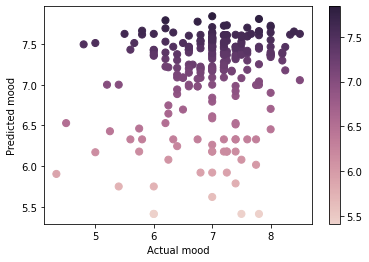

In [167]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(y_test, test_preds, c=test_preds, s=50, cmap=cmap)
ax.set_xlabel('Actual mood')
ax.set_ylabel('Predicted mood')
f.colorbar(points)
plt.show()

In [168]:
#Nested Cross Validation kNN
MSE_list_cv = []
MAE_list_cv =[]

attributes = ['circumplex.arousal', 'circumplex.valence', 'activity',
       'screen', 'call', 'sms', 'appCat.builtin', 'appCat.communication',
       'appCat.entertainment', 'appCat.finance', 'appCat.game',
       'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel',
       'appCat.unknown', 'appCat.utilities', 'appCat.weather']

X, y = df[attributes], df[['mood']]

seeds = list(range(100,201,1))
tic = time.perf_counter()
for i in seeds:
    cv_outer = KFold(n_splits=15, shuffle=True, random_state=i)
    for train_i, val_i in cv_outer.split(X, y):
        X_train, X_val = X.iloc[train_i,:], X.iloc[val_i,:]
        y_train, y_val = y.iloc[train_i,:], y.iloc[val_i,:]
        
        knn_model = KNeighborsRegressor(n_neighbors = 12)
        knn_model.fit(X_train, y_train)
        
        test_preds = knn_model.predict(X_val)
        mse_test = mean_squared_error(y_val, test_preds)
        mae_test = mean_absolute_error(y_val, test_preds)
        
        MSE_list_cv.append(mse_test)
        MAE_list_cv.append(mae_test)

toc = time.perf_counter()
print(f"Nested cross validation for kNN took {toc - tic:0.4f} seconds")
print('Mean MSE: %.3f (%.3f)' % (np.mean(MSE_list_cv), np.std(MSE_list_cv)))
print('Mean MAE: %.3f (%.3f)' % (np.mean(MAE_list_cv), np.std(MAE_list_cv)))

Nested cross validation for kNN took 11.3131 seconds
Mean MSE: 0.428 (0.100)
Mean MAE: 0.489 (0.048)


1515


{'whiskers': [<matplotlib.lines.Line2D at 0x21c1bbb7760>,
 'caps': [<matplotlib.lines.Line2D at 0x21c276993a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x21c1c6401c0>],
 'medians': [<matplotlib.lines.Line2D at 0x21c1c9705b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x21c1c970370>],
 'means': []}

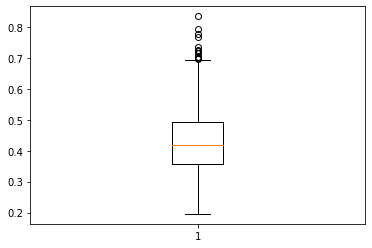

In [169]:
print(len(MSE_list_cv))
plt.boxplot(MSE_list_cv)

In [170]:
attributes =['mood','circumplex.arousal', 'circumplex.valence', 'activity',
       'screen', 'call', 'sms', 'appCat.builtin', 'appCat.communication',
       'appCat.entertainment', 'appCat.finance', 'appCat.game',
       'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel',
       'appCat.unknown', 'appCat.utilities', 'appCat.weather']
X = df[attributes]
y = df[['mood']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train.values.ravel())
train_preds = rf_model.predict(X_train)

rf_mse = mean_squared_error(y_train, train_preds)
rf_mae = mean_absolute_error(y_train, train_preds)
print("Random Forest training mse = ",rf_mse," & mae = ",rf_mae," & rmse = ", sqrt(rf_mse))

test_preds = rf_model.predict(X_test)

rf_test_mse = mean_squared_error(y_test, test_preds)
rf_test_mae = mean_absolute_error(y_test, test_preds)

print("Random Forest test mse = ",rf_test_mse," & mae = ",rf_test_mae," & rmse = ", sqrt(rf_test_mse))

Random Forest training mse =  0.00027682493254844006  & mae =  0.002203458425316724  & rmse =  0.016638056753973406
Random Forest test mse =  0.00018024302496330442  & mae =  0.0031556534508118132  & rmse =  0.013425461815643603


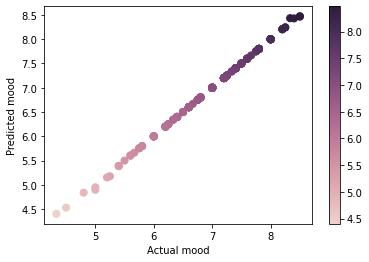

In [171]:
#RF plot
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(y_test, test_preds, c=test_preds, s=50, cmap=cmap)
ax.set_xlabel('Actual mood')
ax.set_ylabel('Predicted mood')
f.colorbar(points)
plt.show()

In [172]:
#RF with nested CV

MSE_list_cv_rf = []
MAE_list_cv_rf =[]
run = 0
attributes =['mood','circumplex.arousal', 'circumplex.valence', 'activity',
       'screen', 'call', 'sms', 'appCat.builtin', 'appCat.communication',
       'appCat.entertainment', 'appCat.finance', 'appCat.game',
       'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel',
       'appCat.unknown', 'appCat.utilities', 'appCat.weather']

X, y = df[attributes], df[['mood']]

n_splits = 10 

seeds = list(range(100,201,1))
tic = time.perf_counter()
for i in seeds:
    cv_outer = KFold(n_splits=n_splits, shuffle=True, random_state=i)
    for train_i, val_i in cv_outer.split(X, y):
        X_train, X_val = X.iloc[train_i,:], X.iloc[val_i,:]
        y_train, y_val = y.iloc[train_i,:], y.iloc[val_i,:]
        #scaler = preprocessing.StandardScaler().fit(X_train)
        #X_train = scaler.transform(X_train)
        #X_val = scaler.transform(X_val)
        
        rf_model = RandomForestRegressor()
        rf_model.fit(X_train, y_train.values.ravel())
        
        test_preds = rf_model.predict(X_val)

        rf_test_mse = mean_squared_error(y_val, test_preds)
        rf_test_mae = mean_absolute_error(y_val, test_preds)
        
        MSE_list_cv_rf.append(rf_test_mse)
        MAE_list_cv_rf.append(rf_test_mae)
        
        run += 1
        if run == round(n_splits * 101 / 4):
            print("25% done!")
        elif run == round(n_splits * 101 / 2):
            print("50% done!")
        elif run == round(n_splits * 101 * 0.75):
            print("75% done!")
toc = time.perf_counter()
print(f"Nested cross validation for Random Forest took {toc - tic:0.4f} seconds")
print('Mean MSE for RF with nested CV: %.6f (%.6f)' % (np.mean(MSE_list_cv_rf), np.std(MSE_list_cv_rf)))
print('Mean MAE for RF with nested CV: %.6f (%.6f)' % (np.mean(MAE_list_cv_rf), np.std(MAE_list_cv_rf)))


25% done!
50% done!
75% done!
Nested cross validation for Random Forest took 348.2474 seconds
Mean MSE for RF with nested CV: 0.001084 (0.001659)
Mean MAE for RF with nested CV: 0.004261 (0.003061)


In [173]:
print('Mean MSE for RF with nested CV: %.7f (%.7f)' % (np.mean(MSE_list_cv_rf), np.std(MSE_list_cv_rf)))
print('Mean MAE for RF with nested CV: %.7f (%.7f)' % (np.mean(MAE_list_cv_rf), np.std(MAE_list_cv_rf)))

Mean MSE for RF with nested CV: 0.0010836 (0.0016595)
Mean MAE for RF with nested CV: 0.0042614 (0.0030615)


{'whiskers': [<matplotlib.lines.Line2D at 0x21c2d96d760>,
 'caps': [<matplotlib.lines.Line2D at 0x21c2d96de20>,
 'boxes': [<matplotlib.lines.Line2D at 0x21c2d96d3d0>],
 'medians': [<matplotlib.lines.Line2D at 0x21c2d9af520>],
 'fliers': [<matplotlib.lines.Line2D at 0x21c2d9af880>],
 'means': []}

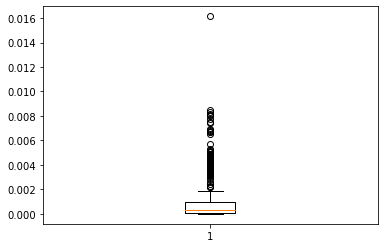

In [174]:
plt.boxplot(MSE_list_cv_rf)

ARIMA test mse =  1.0553933440119592  & mae =  0.4904645065973956  & rmse =  1.027323388233695


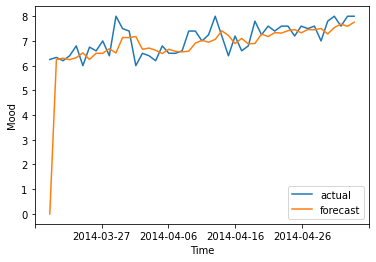

In [175]:
# ARIMA example
from statsmodels.tsa.arima.model import ARIMA
from random import random

df_user1 = df_no_delta[df_no_delta['id']==1]
data1 = df_user1['mood'].values


model = ARIMA(data1, order=(1, 1, 1))
model_fit = model.fit()
# make prediction
predictions = model_fit.predict()

f, ax = plt.subplots()
x = df_user1['mood'].index

plt.plot(x, df_user1['mood'], label='actual')
plt.plot(x, predictions, label='forecast')
plt.xlabel('Time')
plt.ylabel('Mood')
ymin, ymax = ax.get_xlim()
ax.set_xticks(np.round(np.linspace(ymin, ymax, 6), 2))
plt.legend()

arima_test_mse = mean_squared_error(df_user1['mood'].values, predictions)
arima_test_mae = mean_absolute_error(df_user1['mood'].values, predictions)

print("ARIMA test mse = ",arima_test_mse," & mae = ",arima_test_mae," & rmse = ", sqrt(arima_test_mse))

C:\Users\ysijp\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\ysijp\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ysijp\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\ysijp\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ysijp\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:9

ARIMA all users mse =  0.33113106257870556  & mae =  0.4212675324053116  & rmse =  0.5754398861555441


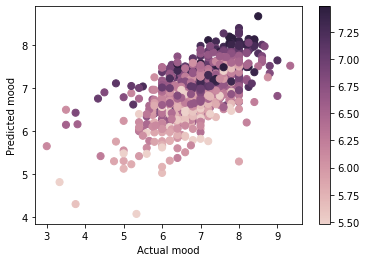

In [176]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()

MSE_list = []
MAE_list = []
unique_users = df_no_delta['id'].unique()
for uu in unique_users:
    df_u = df_no_delta[df_no_delta['id'] == uu]
    data1 = df_u['mood'].values
    #p: the number of lag observations in the model; also known as the lag order.
    #d: the number of times that the raw observations are differenced; also known as the degree of differencing.
    #q: the size of the moving average window; also known as the order of the moving average.
    p = 1
    d = 1
    q = 5 
    model = ARIMA(data1, order=(p, d, q))  
    model_fit = model.fit()
    # make prediction
    predictions = model_fit.predict()
    
    # Exclude first 5 predictions as these are before the moving average window works:
    actual = df_u['mood'].iloc[5:].values
    predictions = predictions[5:]
    
    arima_test_mse = mean_squared_error(actual, predictions)
    arima_test_mae = mean_absolute_error(actual, predictions)
    MSE_list.append(arima_test_mse)
    MAE_list.append(arima_test_mae)
    
    x = df_u['mood'].index
    # Plot all users
    points = ax.scatter(actual, predictions, c=predictions, s=50, cmap=cmap)

total_mse = sum(MSE_list)/(len(MSE_list))
total_mae = sum(MAE_list)/(len(MAE_list))

print("ARIMA all users mse = ",total_mse," & mae = ",total_mae," & rmse = ", sqrt(total_mse))

ax.set_xlabel('Actual mood')
ax.set_ylabel('Predicted mood')
f.colorbar(points)
plt.show()

In [177]:
def prep_data(datain, time_step):

    # First, create an array with indices for y elements based on the chosen time_step
    y_indices = np.arange(start=time_step, stop=len(datain), step=time_step)
    
    # Create y array based on the above indices 
    y_tmp = datain[y_indices]
    y_tmp = y_tmp[:, 0]
    
    # We want to have the same number of rows for X as we do for y
    rows_X = len(y_tmp)

    # Since the last element in y_tmp may not be the last element of the datain, 
    # let's ensure that X array stops with the last y
    X_tmp = datain[range(time_step*rows_X)]
    X_tmp = X_tmp[:, 1:]
    
    # Now take this array and reshape it into the desired shape
    X_tmp = np.reshape(X_tmp, (rows_X, time_step, 18))
    return X_tmp, y_tmp

In [178]:
attributes = ['mood','circumplex.arousal', 'circumplex.valence', 'activity',
       'screen', 'call', 'sms', 'appCat.builtin', 'appCat.communication',
       'appCat.entertainment', 'appCat.finance', 'appCat.game',
       'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel',
       'appCat.unknown', 'appCat.utilities', 'appCat.weather']
X = df_no_delta[attributes]


scaler = MinMaxScaler((0, 1))
X_scaled=scaler.fit_transform(X)


#Create training and testing samples
train_data, test_data = train_test_split(X_scaled, test_size=0.4, random_state=301, shuffle=False)

#Prepare input X and target y arrays using previously defined function
time_step = 5
X_train, y_train = prep_data(train_data, time_step)
X_test, y_test = prep_data(test_data, time_step)

##Neural Network
model = Sequential(name="First-RNN-Model") # Model
model.add(Input(shape=(time_step, len(attributes)-1), name='Input-Layer')) # Input Layer - need to speicfy the shape of inputs
model.add(SimpleRNN(units=1, activation='tanh', name='Hidden-Recurrent-Layer')) # Hidden Recurrent Layer, Tanh(x) = sinh(x)/cosh(x) = ((exp(x) - exp(-x))/(exp(x) + exp(-x)))
model.add(Dense(units=64, activation='tanh', name='Hidden-Layer')) # Hidden Layer, Tanh(x) = sinh(x)/cosh(x) = ((exp(x) - exp(-x))/(exp(x) + exp(-x)))
model.add(Dense(units=1, activation='linear', name='Output-Layer')) # Output Layer, Linear(x) = x


#Define keras model
model.compile(optimizer='rmsprop', # default='rmsprop'
              loss='mean_squared_error',
              metrics=['MeanSquaredError', 'MeanAbsoluteError'],
              run_eagerly=None, 
              steps_per_execution=None)


#Fit keras model on the dataset
model.fit(X_train, 
          y_train, 
          batch_size=1, # Number of samples per gradient update. If unspecified, batch_size will default to 32.
          epochs=20 # default=1, Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided
         )


# Use model to make predictions
# Predict the result on training data
pred_train = model.predict(X_train)
# Predict the result on test data
pred_test = model.predict(X_test)

#Model Performance Summary
print("")
print('RNN summary')
model.summary()
print("")
print(' Weights and Biases')
print("The last parameter in each layer is bias, the rest are weights")
print("")
for layer in model.layers:
    print(layer.name)
    for item in layer.get_weights():
        print("  ", item)

Epoch 1/20
151/151 [==============================] - 3s 1ms/step - loss: 0.0521 - mean_squared_error: 0.0521 - mean_absolute_error: 0.1658
Epoch 2/20
151/151 [==============================] - 0s 1ms/step - loss: 0.0189 - mean_squared_error: 0.0189 - mean_absolute_error: 0.1009
Epoch 3/20
151/151 [==============================] - 0s 1ms/step - loss: 0.0187 - mean_squared_error: 0.0187 - mean_absolute_error: 0.0978
Epoch 4/20
151/151 [==============================] - 0s 1ms/step - loss: 0.0191 - mean_squared_error: 0.0191 - mean_absolute_error: 0.0991
Epoch 5/20
151/151 [==============================] - 0s 1ms/step - loss: 0.0191 - mean_squared_error: 0.0191 - mean_absolute_error: 0.0973
Epoch 6/20
151/151 [==============================] - 0s 1ms/step - loss: 0.0184 - mean_squared_error: 0.0184 - mean_absolute_error: 0.0958
Epoch 7/20
151/151 [==============================] - 0s 1ms/step - loss: 0.0184 - mean_squared_error: 0.0184 - mean_absolute_error: 0.0994
Epoch 8/20
151/151 [

In [ ]:
print('---------- Evaluation on Training Data ----------')
print("MSE: ", mean_squared_error(y_train, pred_train))
print("")

print('---------- Evaluation on Test Data ----------')
print("MSE: ", mean_squared_error(y_test, pred_test))
print("")

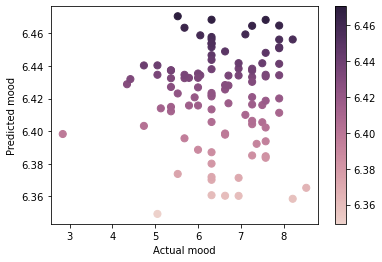

In [179]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(y_test * 10, pred_test * 10, c=pred_test * 10, s=50, cmap=cmap)
ax.set_xlabel('Actual mood')
ax.set_ylabel('Predicted mood')
f.colorbar(points)
plt.show()